In [ ]:
# Install dependencies as needed:
# !pip install kagglehub[pandas-datasets]
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [ ]:
# import required files
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import kagglehub
from kagglehub import KaggleDatasetAdapter
from PIL import Image
import numpy as np

In [ ]:
# Create a location for the SAM weights
HOME = os.getcwd()
!mkdir -p {HOME}/weights
print("HOME:", HOME)
print("Weights:", os.listdir(f"{HOME}/weights"))

HOME: /content
Weights: ['sam_vit_h_4b8939.pth']


In [ ]:
# Download SAM Weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth -P {HOME}/weights

In [ ]:
# download the dataset and test
file_path = kagglehub.dataset_download("thezaza102/tray-food-segmentation")
print("File path:", file_path)

Using Colab cache for faster access to the 'tray-food-segmentation' dataset.
File path: /kaggle/input/tray-food-segmentation


In [ ]:
# List files in the downloaded directory
files_in_directory = os.listdir(file_path)
print("Files in directory:", files_in_directory)

# Assuming 'classes.csv' is the data file, construct the full path
data_file_path = os.path.join(file_path, "classes.csv")

# Load the dataset using pandas read_csv
df = pd.read_csv(data_file_path)
print("First 5 records:", df.head())


Files in directory: ['TrayDataset', 'classes.csv']
First 5 records:    _id      _class       _name
0    0  background  background
1    1        tray        tray
2    2     cutlery     cutlery
3    3        form        form
4    4       straw       straw


In [ ]:


# Assuming file_path is defined from earlier cells
file_path = "/root/.cache/kagglehub/datasets/thezaza102/tray-food-segmentation/versions/1" # Replace with your actual file_path

train_images_dir = os.path.join(file_path, "TrayDataset/TrayDataset/XTrain")
train_masks_dir = os.path.join(file_path, "TrayDataset/TrayDataset/yTrain")
test_images_dir = os.path.join(file_path, "TrayDataset/TrayDataset/XTest")
test_masks_dir = os.path.join(file_path, "TrayDataset/TrayDataset/yTest")

# Function to convert and save images as JPG
def convert_to_jpg(directory, is_mask=False):
    for filename in os.listdir(directory):
        try:
            filepath = os.path.join(directory, filename)
            # Skip directories
            if os.path.isdir(filepath):
                continue
            img = Image.open(filepath)

            if is_mask:
                # Convert masks to grayscale before saving as JPG
                img = img.convert("L")
            else:
                # Ensure images are in RGB format
                img = img.convert("RGB")

            # Create the new filename with .jpg extension
            new_filename = os.path.splitext(filename)[0] + ".jpg"
            new_filepath = os.path.join(directory, new_filename)

            # Save the image as JPG
            img.save(new_filepath, "jpeg")

            # Optional: Remove the original file if you want to replace them
            if filepath != new_filepath:
                os.remove(filepath)

        except Exception as e:
            print(f"Error processing file {filename} in {directory}: {e}")

print("Converting training images to JPG...")
convert_to_jpg(train_images_dir, is_mask=False)
print("Converting training masks to JPG...")
convert_to_jpg(train_masks_dir, is_mask=True)
print("Converting testing images to JPG...")
convert_to_jpg(test_images_dir, is_mask=False)
print("Converting testing masks to JPG...")
convert_to_jpg(test_masks_dir, is_mask=True)

print("\nConversion complete.")

Converting training images to JPG...
Converting training masks to JPG...
Converting testing images to JPG...
Converting testing masks to JPG...

Conversion complete.


In [ ]:
from datasets import Dataset
dataset_dict = {
    "image": [],
    "label": []
}

# Assuming train_images_dir and train_masks_dir are defined from earlier cells
train_images_dir = os.path.join(file_path, "TrayDataset/TrayDataset/XTrain")
train_masks_dir = os.path.join(file_path, "TrayDataset/TrayDataset/yTrain")

# Get sorted lists of image and mask filenames
image_filenames = sorted(os.listdir(train_images_dir))
mask_filenames = sorted(os.listdir(train_masks_dir))

# Populate the dictionary with full file paths
for img_filename, mask_filename in zip(image_filenames, mask_filenames):
    dataset_dict["image"].append(os.path.join(train_images_dir, img_filename))
    dataset_dict["label"].append(os.path.join(train_masks_dir, mask_filename))

# Create a Hugging Face Dataset
train_dataset = Dataset.from_dict(dataset_dict)

print(train_dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 1241
})


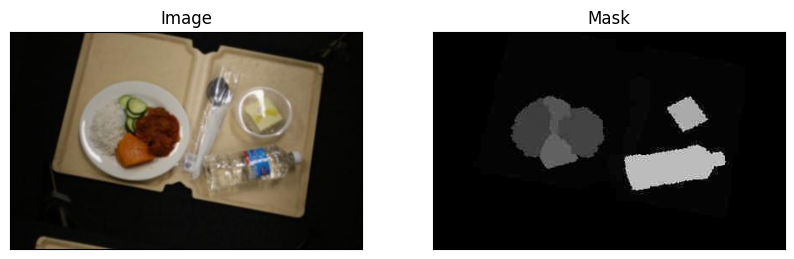

In [ ]:
img_num = random.randint(0, len(train_dataset) - 1) # Use len(train_dataset) for the upper bound
example_image_path = train_dataset[img_num]["image"]
example_mask_path = train_dataset[img_num]["label"]

# Open the images using Pillow
example_image = Image.open(example_image_path).convert("RGB")
example_mask = Image.open(example_mask_path).convert("L")


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image))  # Convert Pillow image to numpy array for plotting
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(np.array(example_mask), cmap='gray')  # Convert Pillow image to numpy array for plotting
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [ ]:
def get_bounding_box(ground_truth_map):

  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image_item = item["image"]
    mask_item = item["label"]

    # Handle image: Open if path, convert to RGB and then numpy if needed
    if isinstance(image_item, str):
        image = Image.open(image_item).convert("RGB")
    elif isinstance(image_item, Image.Image):
        image = image_item.convert("RGB")
    else: # Assume it's already in a format that np.array can handle (like numpy array)
        image = Image.fromarray(np.array(image_item)).convert("RGB")


    # Handle mask: Open if path, convert to L (grayscale) and then numpy if needed
    if isinstance(mask_item, str):
        ground_truth_mask = np.array(Image.open(mask_item).convert("L"))
    elif isinstance(mask_item, Image.Image):
        ground_truth_mask = np.array(mask_item.convert("L"))
    else: # Assume it's already in a format that np.array can handle (like numpy array)
         ground_truth_mask = np.array(mask_item)


    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
train_dataset = SAMDataset(dataset=train_dataset, processor=processor)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 416)


In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))

for k,v in batch.items():
  print(k,v.shape)

TypeError: Cannot handle this data type: (1, 1), <U119